In [1]:
## Created 1/15/24 by Tazein Shah
# Made to test the new randomization (maybe the stem plot if I can get that to work)

In [2]:
#loading the packages#

#using Pkg
#Pkg.add("DataFrames")
#Pkg.add("Random")
#Pkg.add("RollingFunctions")
#Pkg.add("XLSX")
#Pkg.add("Distributions") 

using DataFrames
using Random
using RollingFunctions
using XLSX
using Distributions
using Plots

# setting the variables and constants #
n_obs = 200000  # number of steps
n_constant_nodes = 100000 # for the constant nodes 
p = 22  # number of variables

#creates an "empty" time series  #integers not floats
empty_series = falses(p, n_obs)

# Saving the empty time series as the time series (so it can be regenerated later)
time_series = empty_series

# Saving a network_score matrix 
network_scores = zeros(n_obs, 4)

#example mutation profile mutation_profile[1]

200000×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 ⋮              
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

In [3]:
# making a function for the constant nodes + mutated genes #

function patient_matrix(mutation_profile)
    ##preparing the mutation_profile
    mutation_profile = split(mutation_profile, ',')
    
    # Remove repeated values
    mutation_profile = unique(mutation_profile)
    
    # Join back together
    join(mutation_profile, ",")

    println(mutation_profile)    
    
    #knocking in genes
    for col in 1:n_obs
        if any(x -> occursin.("NPM1", x), mutation_profile)
            time_series[6,col] = 1
            end
    
        if any(x -> occursin.("DNMT3A", x), mutation_profile)
            time_series[4,col] = 0
            end
    
        if any(x -> occursin.("FLT3", x), mutation_profile)
            time_series[1,col] = 1
            end
    end
    
    println("done knocking in/out genes")
    
    #doing the constant nodes (they do not change, but they still need noise)    
    for col in (n_constant_nodes + 1) :n_obs
        #simulate the constant nodes for only a couple of steps
        time_series[1,col] = time_series[1,col-1] #FLT3=FLT3
        time_series[4,col] = time_series[4,col-1] #DNMT3A = DNMT3A
        time_series[6,col] = time_series[6,col-1] #NPM1 = NPM1
    end
    
    println("created patient matrix")
end

patient_matrix (generic function with 1 method)

In [4]:
# score_personal function #

#creating the function for personal score
function score_personal(mutation_profile)
    #putting the constant variables for randomization out of the for statement
        q = 0.001 #there are still a lot of ones???
        x = time_series[:,n_obs] #the current state of the time_series is x (is the length of genes)
        n = (length(x)) #number of genes to be changed (so none of the constant nodes)
        y = zeros(Bool,n) #initialize next state
    
    # Specify the indices of columns that should NOT be perturbed
    constant_nodes = [1,4,6]  

    for col in 2:((n_obs-1))
        time_series[2,col] = time_series[1,col-1] #AKT = FLT3
        time_series[3,col] = !(time_series[1,col-1]) #CEBPA = !FLT3
        time_series[5,col] = !(time_series[2,col-1]) #GSK3B = !AKT
        time_series[7,col] = time_series[6,col-1] #ARF = NPM1
        time_series[8,col] = !time_series[6,col-1] #HOXA9 = !NPM1
        time_series[9,col] = time_series[6,col-1] #FBXW7 = NPM1
        time_series[10,col] = time_series[1,col-1] #ERK = FLT3
        time_series[11,col] = time_series[6,col-1] #CDKN2A = NPM1
        time_series[12,col] = time_series[1,col-1] #STAT5A = FLT3
        time_series[13,col] = !(time_series[3,col-1]) #SOX4 = !CEBPA
        time_series[14,col] = !(time_series[4,col-1] | time_series[5,col-1]) #CCND1 = !(DNMT3A | GSK3B)
        time_series[15,col] = !(time_series[4,col-1] & !(time_series[8,col-1])) #MEIS1 = !(DNMT3A & !HOXA9)
        time_series[16,col] = !(time_series[5,col-1] & time_series[9,col-1]) & time_series[10,col-1] #MYC = !(GSK3B&FBXW7)&ERK
        time_series[17,col] = !time_series[10,col-1] #ETV6 = !ERK
        time_series[18,col] = time_series[7,col-1] #TP53 = ARF
        time_series[19,col] = time_series[10,col-1] & !(time_series[18,col-1]) #BCL2 = ERK&!TP53
        time_series[20,col] = time_series[18,col-1] & !(time_series[19,col-1]) #Apoptosis = TP53&!BCL2
        time_series[21,col] = (time_series[3,col-1] | time_series[17,col-1]) & !(time_series[15,col-1]) #Differentiation = (CEBPA | ETV6) & !MEIS1
        time_series[22,col] = (time_series[16,col-1] | time_series[14,col-1] | time_series[13,col-1] | time_series[15,col-1] | time_series[12,col-1]) #Proliferation = (MYC | CCND1| SOX4 | MEIS1| STAT5A)
        
        # Generate a random perturbation vector where the likelihood of a value being 1 is based on q
        gam = transpose(rand(Bool, 1, n - length(constant_nodes)) .< q)
        if any(gam)
            # Perturb only the columns that are not in the list of invalid columns
            noise_affected_nodes = setdiff(1:n, constant_nodes)
            y[noise_affected_nodes] .= xor.(x[noise_affected_nodes], gam)
            time_series[:, col+1] = y  # the next step is created
        end
    end
    
    #computing the scores
    for col in 1:n_obs
        network_scores[col,1] = time_series[20,col]
		network_scores[col,2] = time_series[21,col]
		network_scores[col,3] = time_series[22,col]
		network_scores[col,4] = (time_series[20,col] - (time_series[21,col] + time_series[22,col]))
	end  
    
    println("finished getting the scores")
end

score_personal (generic function with 1 method)

In [5]:
time_series = empty_series
mutation_profile = "FLT3,DNMT3A,NPM1"

patient_matrix(mutation_profile)
time_series
score_personal(mutation_profile)

SubString{String}["FLT3", "DNMT3A", "NPM1"]
done knocking in/out genes
created patient matrix
finished getting the scores


In [6]:
network_scores

200000×4 Matrix{Float64}:
 0.0  0.0  0.0   0.0
 0.0  0.0  0.0   0.0
 0.0  0.0  1.0  -1.0
 0.0  0.0  1.0  -1.0
 1.0  0.0  1.0   0.0
 0.0  0.0  1.0  -1.0
 0.0  0.0  1.0  -1.0
 0.0  0.0  1.0  -1.0
 0.0  0.0  1.0  -1.0
 0.0  0.0  1.0  -1.0
 0.0  0.0  1.0  -1.0
 0.0  0.0  1.0  -1.0
 0.0  0.0  1.0  -1.0
 ⋮              
 0.0  0.0  1.0  -1.0
 0.0  0.0  1.0  -1.0
 0.0  0.0  1.0  -1.0
 0.0  0.0  1.0  -1.0
 0.0  0.0  1.0  -1.0
 0.0  0.0  1.0  -1.0
 0.0  0.0  1.0  -1.0
 0.0  0.0  1.0  -1.0
 0.0  0.0  1.0  -1.0
 0.0  0.0  1.0  -1.0
 0.0  0.0  1.0  -1.0
 0.0  1.0  1.0  -2.0

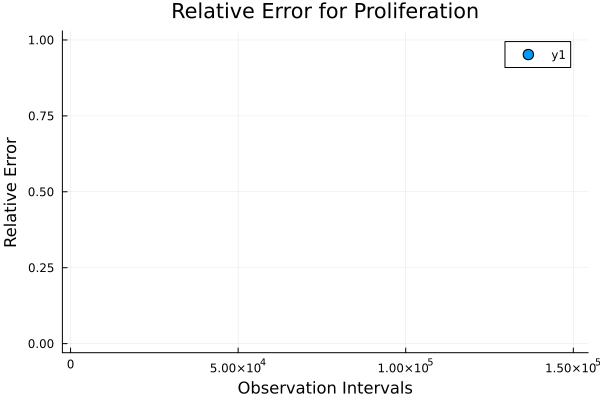

In [7]:
#getting the relative error points to check if the score converges

#proliferation
s1 = mean(network_scores[500:1000,1])
s2 = mean(network_scores[1000:2000,1])
s3 = mean(network_scores[2000:4000,1])
s4 = mean(network_scores[4000:8000,1])
s5 = mean(network_scores[8000:16000,1])
s6 = mean(network_scores[16000:32000,1])
s7 = mean(network_scores[32000:64000,1])
s8 = mean(network_scores[64000:100000,1])
s9 = mean(network_scores[100000:150000,1])

point_1 = ((s2-s1)/s1)
point_2 = ((s3-s2)/s2)
point_3 = ((s4-s3)/s3)
point_4 = ((s5-s4)/s4)
point_5 = ((s6-s5)/s5)
point_6 = ((s7-s6)/s6)
point_7 = ((s8-s7)/s7)
point_8 = ((s9-s8)/s8)

#saving into vectors
a = [point_1, point_2, point_3, point_4,point_5,point_6,point_7, point_8]
b = [2000, 4000, 8000, 16000, 32000, 64000,100000,150000]

#create a new dataframe for the relative_error
prolif_relative_error = DataFrame(observation_intervals=b, relative_error=a)

scatter(prolif_relative_error.observation_intervals, prolif_relative_error.relative_error, xlabel = "Observation Intervals", ylabel = "Relative Error", title = "Relative Error for Proliferation")

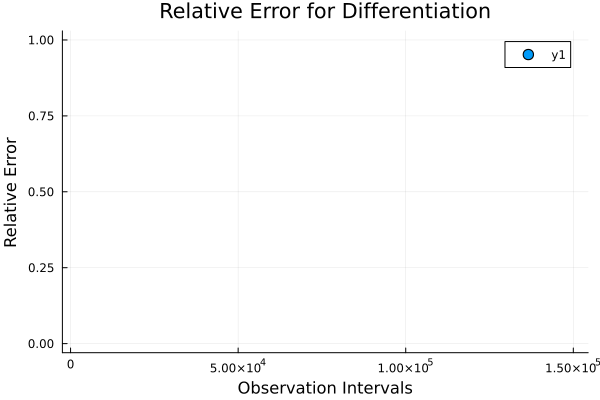

In [8]:
#getting the relative error points to check if the score converges

#differentiation
s1 = mean(network_scores[500:1000,2])
s2 = mean(network_scores[1000:2000,2])
s3 = mean(network_scores[2000:4000,2])
s4 = mean(network_scores[4000:8000,2])
s5 = mean(network_scores[8000:16000,2])
s6 = mean(network_scores[16000:32000,2])
s7 = mean(network_scores[32000:64000,2])
s8 = mean(network_scores[64000:100000,2])
s9 = mean(network_scores[100000:150000,2])

point_1 = ((s2-s1)/s1)
point_2 = ((s3-s2)/s2)
point_3 = ((s4-s3)/s3)
point_4 = ((s5-s4)/s4)
point_5 = ((s6-s5)/s5)
point_6 = ((s7-s6)/s6)
point_7 = ((s8-s7)/s7)
point_8 = ((s9-s8)/s8)

#saving into vectors
a = [point_1, point_2, point_3, point_4,point_5,point_6,point_7, point_8]
b = [2000, 4000, 8000, 16000, 32000, 64000,100000,150000]

#create a new dataframe for the relative_error
diff_relative_error = DataFrame(observation_intervals=b, relative_error=a)

scatter(diff_relative_error.observation_intervals, diff_relative_error.relative_error, xlabel = "Observation Intervals", ylabel = "Relative Error", title = "Relative Error for Differentiation")

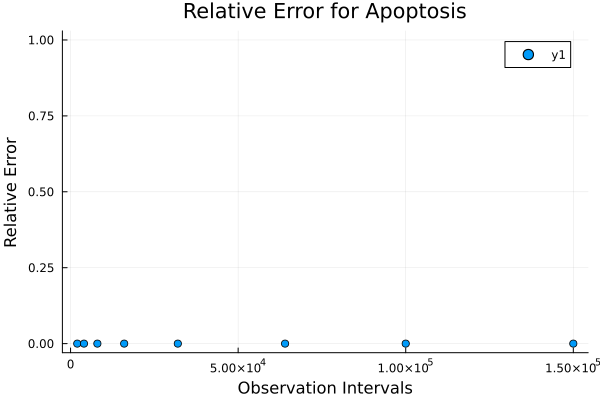

In [9]:
#getting the relative error points to check if the score converges

#differentiation
s1 = mean(network_scores[500:1000,3])
s2 = mean(network_scores[1000:2000,3])
s3 = mean(network_scores[2000:4000,3])
s4 = mean(network_scores[4000:8000,3])
s5 = mean(network_scores[8000:16000,3])
s6 = mean(network_scores[16000:32000,3])
s7 = mean(network_scores[32000:64000,3])
s8 = mean(network_scores[64000:100000,3])
s9 = mean(network_scores[100000:150000,3])

point_1 = ((s2-s1)/s1)
point_2 = ((s3-s2)/s2)
point_3 = ((s4-s3)/s3)
point_4 = ((s5-s4)/s4)
point_5 = ((s6-s5)/s5)
point_6 = ((s7-s6)/s6)
point_7 = ((s8-s7)/s7)
point_8 = ((s9-s8)/s8)

#saving into vectors
a = [point_1, point_2, point_3, point_4,point_5,point_6,point_7, point_8]
b = [2000, 4000, 8000, 16000, 32000, 64000,100000,150000]

#create a new dataframe for the relative_error
apop_relative_error = DataFrame(observation_intervals=b, relative_error=a)

scatter(apop_relative_error.observation_intervals, apop_relative_error.relative_error, xlabel = "Observation Intervals", ylabel = "Relative Error", title = "Relative Error for Apoptosis")

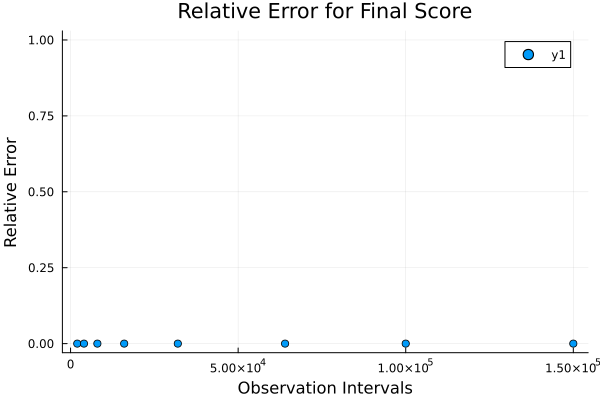

In [10]:
#getting the relative error points to check if the score converges

#differentiation
s1 = mean(network_scores[500:1000,4])
s2 = mean(network_scores[1000:2000,4])
s3 = mean(network_scores[2000:4000,4])
s4 = mean(network_scores[4000:8000,4])
s5 = mean(network_scores[8000:16000,4])
s6 = mean(network_scores[16000:32000,4])
s7 = mean(network_scores[32000:64000,4])
s8 = mean(network_scores[64000:100000,4])
s9 = mean(network_scores[100000:150000,4])

point_1 = ((s2-s1)/s1)
point_2 = ((s3-s2)/s2)
point_3 = ((s4-s3)/s3)
point_4 = ((s5-s4)/s4)
point_5 = ((s6-s5)/s5)
point_6 = ((s7-s6)/s6)
point_7 = ((s8-s7)/s7)
point_8 = ((s9-s8)/s8)

#saving into vectors
a = [point_1, point_2, point_3, point_4,point_5,point_6,point_7,point_8]
b = [2000, 4000, 8000, 16000, 32000, 64000,100000,150000]

#create a new dataframe for the relative_error
final_relative_error = DataFrame(observation_intervals=b, relative_error=a)

scatter(final_relative_error.observation_intervals, final_relative_error.relative_error, xlabel = "Observation Intervals", ylabel = "Relative Error", title = "Relative Error for Final Score")